# Importing Basic Libraries

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Zip path

In [3]:
Archive=r'/content/drive/My Drive/Sandy/Facemask detection/archive.zip'

In [4]:
from zipfile import ZipFile

In [5]:
with ZipFile(Archive,'r') as z:
    z.extractall()
print('Archive Extraction done')

Archive Extraction done


In [6]:
import os
for dirname, _, filenames in os.walk(r'/content/images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/images/maksssksksss72.png
/content/images/maksssksksss483.png
/content/images/maksssksksss85.png
/content/images/maksssksksss489.png
/content/images/maksssksksss119.png
/content/images/maksssksksss291.png
/content/images/maksssksksss435.png
/content/images/maksssksksss249.png
/content/images/maksssksksss357.png
/content/images/maksssksksss317.png
/content/images/maksssksksss420.png
/content/images/maksssksksss47.png
/content/images/maksssksksss289.png
/content/images/maksssksksss75.png
/content/images/maksssksksss515.png
/content/images/maksssksksss20.png
/content/images/maksssksksss814.png
/content/images/maksssksksss125.png
/content/images/maksssksksss523.png
/content/images/maksssksksss69.png
/content/images/maksssksksss53.png
/content/images/maksssksksss600.png
/content/images/maksssksksss531.png
/content/images/maksssksksss164.png
/content/images/maksssksksss613.png
/content/images/maksssksksss735.png
/content/images/maksssksksss310.png
/content/images/maksssksksss664.png

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
!pip install mtcnn
from mtcnn import MTCNN
import cv2
import json

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 2.3MB 4.3MB/s 


In [8]:
lr = 1e-4
bs = 32
epochs = 20

In [10]:
annotations_dir=r'/content/annotations'
images_dir=r'/content/images'

In [11]:
import xml.etree.ElementTree as et

In [12]:
#parsing data in a csv format

dic = {"image": [],"Dimensions": []}
for i in range(1,116):
    dic[f'Object {i}']=[]

for file in os.listdir(r"/content/annotations"):
    row = []
    xml = et.parse(r"/content/annotations/"+ file) 
    root = xml.getroot()
    img = root[1].text
    row.append(img)
    h,w = root[2][0].text,root[2][1].text
    row.append([h,w])

    for i in range(4,len(root)):
        temp = []
        temp.append(root[i][0].text)
        for point in root[i][5]:
            temp.append(point.text)
        row.append(temp)
        
    for i in range(len(row),119):
        row.append(0)
        
    for i,each in enumerate(dic):
        dic[each].append(row[i])
        
df = pd.DataFrame(dic)
df.head()

,image,Dimensions,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,Object 9,Object 10,Object 11,Object 12,Object 13,Object 14,Object 15,Object 16,Object 17,Object 18,Object 19,Object 20,Object 21,Object 22,Object 23,Object 24,Object 25,Object 26,Object 27,Object 28,Object 29,Object 30,Object 31,Object 32,Object 33,Object 34,Object 35,Object 36,Object 37,Object 38,...,Object 76,Object 77,Object 78,Object 79,Object 80,Object 81,Object 82,Object 83,Object 84,Object 85,Object 86,Object 87,Object 88,Object 89,Object 90,Object 91,Object 92,Object 93,Object 94,Object 95,Object 96,Object 97,Object 98,Object 99,Object 100,Object 101,Object 102,Object 103,Object 104,Object 105,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss541.png,"[301, 400]","[with_mask, 104, 144, 213, 285]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,maksssksksss385.png,"[400, 245]","[with_mask, 125, 76, 157, 113]","[without_mask, 385, 25, 396, 46]","[without_mask, 217, 27, 229, 41]","[without_mask, 51, 20, 61, 31]","[without_mask, 87, 15, 97, 27]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,maksssksksss561.png,"[301, 400]","[without_mask, 81, 163, 184, 279]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,maksssksksss837.png,"[301, 400]","[without_mask, 95, 151, 192, 261]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,maksssksksss49.png,"[400, 225]","[with_mask, 352, 102, 370, 123]","[with_mask, 272, 33, 289, 51]","[with_mask, 188, 124, 206, 143]","[with_mask, 20, 54, 41, 72]","[with_mask, 123, 68, 141, 87]","[with_mask, 157, 45, 173, 63]","[without_mask, 95, 211, 113, 225]","[without_mask, 225, 181, 240, 200]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
import glob

In [15]:
image_directories = sorted(glob.glob(os.path.join(r"/content/images","*.png")))
j=0
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            if((info[3]-info[1])>40 and (info[4]-info[2])>40):
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)
                    if(label=="mask_weared_incorrect"):
                        data.append(face)
                        labels.append(label)

                except:
                    pass
                
images = np.array(data, dtype="float32")
labels = np.array(labels)
print(len(images))
print(len(labels))

341
341


In [16]:
labels.shape

(341,)

In [17]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(labels[:10])
labels = to_categorical(labels)
print(labels[:10])

[1 1 1 1 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [18]:
(trainX, testX, trainY, testY) = train_test_split(images, labels,
                                test_size=0.20, stratify=labels, random_state=42)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

272
272
69
69


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [20]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

#contruct headModel that will be on top of the baseModel
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

#consruct the actual trainable model
model = Model(inputs=baseModel.input, outputs=headModel)

#loop base layers to freeze them (they won't be updated during the initial training process)
for layer in baseModel.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [22]:
# compile model
opt = Adam(lr = lr, decay = lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [23]:
his = model.fit(aug.flow(trainX, trainY, batch_size=bs),
               steps_per_epoch=len(trainX)//bs,
               validation_data=(testX, testY),
               validation_steps=len(testX)//bs,
               epochs=epochs)

Epoch 1/20
8/8 [==============================] - 3s 417ms/step - loss: 0.6772 - accuracy: 0.5000 - val_loss: 0.4434 - val_accuracy: 0.7826
Epoch 2/20
8/8 [==============================] - 2s 277ms/step - loss: 0.4063 - accuracy: 0.8083 - val_loss: 0.4306 - val_accuracy: 0.8406
Epoch 3/20
8/8 [==============================] - 2s 302ms/step - loss: 0.4424 - accuracy: 0.8167 - val_loss: 0.4403 - val_accuracy: 0.8406
Epoch 4/20
8/8 [==============================] - 2s 281ms/step - loss: 0.4083 - accuracy: 0.8292 - val_loss: 0.4168 - val_accuracy: 0.8406
Epoch 5/20
8/8 [==============================] - 2s 280ms/step - loss: 0.4246 - accuracy: 0.8125 - val_loss: 0.3957 - val_accuracy: 0.8406
Epoch 6/20
8/8 [==============================] - 2s 301ms/step - loss: 0.3793 - accuracy: 0.8125 - val_loss: 0.3851 - val_accuracy: 0.8406
Epoch 7/20
8/8 [==============================] - 2s 282ms/step - loss: 0.3541 - accuracy: 0.8208 - val_loss: 0.3790 - val_accuracy: 0.8406
Epoch 8/20
8/8 [====

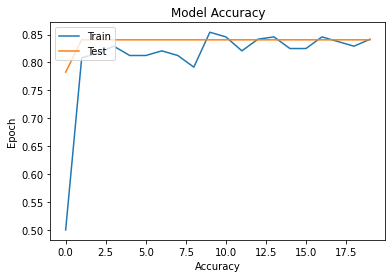

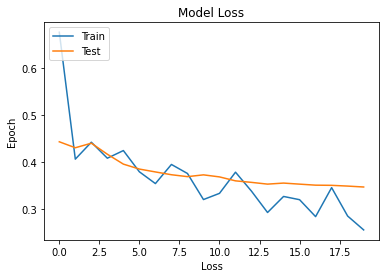

In [24]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
print(model.predict(testX, batch_size=bs))

[[0.03714918 0.8190822  0.14376868]
 [0.06960446 0.8674705  0.06292505]
 [0.02566319 0.95699537 0.01734154]
 [0.00677865 0.97727    0.01595131]
 [0.12303427 0.7792235  0.09774227]
 [0.12691444 0.80436575 0.06871989]
 [0.02198204 0.88313127 0.09488667]
 [0.00914131 0.8889848  0.10187387]
 [0.05585193 0.91822964 0.02591838]
 [0.02585916 0.8839976  0.09014324]
 [0.08435263 0.84044224 0.07520512]
 [0.02614826 0.81205565 0.16179606]
 [0.03960133 0.78417563 0.176223  ]
 [0.14935046 0.7231554  0.12749426]
 [0.32395196 0.6251803  0.05086768]
 [0.04017497 0.83809626 0.12172877]
 [0.13173613 0.7628027  0.1054611 ]
 [0.02931968 0.9150834  0.0555969 ]
 [0.0292263  0.8765799  0.09419385]
 [0.07765227 0.83682555 0.08552217]
 [0.03138209 0.9300913  0.03852656]
 [0.00570611 0.9017348  0.09255915]
 [0.03353842 0.9362364  0.03022512]
 [0.00717313 0.84793043 0.14489646]
 [0.06896452 0.8313642  0.09967124]
 [0.06102328 0.7260342  0.21294247]
 [0.08197823 0.8188408  0.09918099]
 [0.03835066 0.74156904 0.22

In [26]:
pred = model.predict(testX, batch_size=bs)
pred = np.argmax(pred, axis=1)
print(classification_report(testY.argmax(axis=1), pred, target_names=lb.classes_))

                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00         4
            with_mask       0.84      1.00      0.91        58
         without_mask       0.00      0.00      0.00         7

             accuracy                           0.84        69
            macro avg       0.28      0.33      0.30        69
         weighted avg       0.71      0.84      0.77        69

